In [2]:
from functions_ngates import calc_variance
from functions_ngates_cuda import calc_variance_optimized
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

In [3]:
layers1 = np.arange(1, 10)

In [15]:
variances1 = [calc_variance(4, l, n_sim=4, n_sim_noise=20, fast_ent=True, noise='dephasing')[:,-1] for l in layers1]

In [16]:
variances2 = [calc_variance_optimized(4, l, n_sim=3, n_sim_noise=20, fast_ent=True, noise='dephasing')[:,-1] for l in layers1]

In [17]:
var1 = []
var2 = []
var0 = []

for l in range(9):
    resh1 = variances1[l].reshape(-1,20)
    resh2 = variances2[l].reshape(-1,20)
    var1.append(th.std(th.mean(resh1, dim=1)))
    var2.append(th.std(th.mean(resh2, dim=1)).to('cpu').numpy())
    var0.append(th.std(resh2[:,10]).to('cpu').numpy())

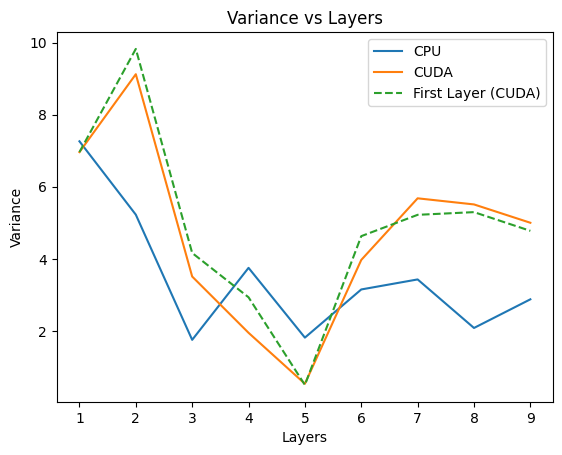

In [18]:
plt.plot(layers1, var1, label='CPU')
plt.plot(layers1, var2, label='CUDA')
plt.plot(layers1, var0, label='First Layer (CUDA)', linestyle='--')
plt.xlabel('Layers')
plt.ylabel('Variance')
plt.title('Variance vs Layers')
plt.legend()
plt.show()